In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator

from pathlib import Path
from MITRotor import BEM, IEA10MW, IEA15MW, BEMGeometry, AerodynamicProperties, NoTipLoss, PrandtlTipLoss, ConstantInduction, KraghAerodynamics, ClassicalMomentum, UnifiedMomentum, MadsenMomentum, NoTangentialInduction, DefaultTangentialInduction, BEMSolution

In [3]:
fontsize = 24
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [4]:
def per_error(A, E):
    error = ((A - E) / E) * 100

    return error

def interp_polars(r,t,R,T,data):
    interpolator = RegularGridInterpolator(
        (r, t), 
        data, 
        bounds_error=False, 
        fill_value=None  # Enables extrapolation
    )

    # Interpolation points
    points_new = np.column_stack((R.ravel(), T.ravel()))

    # Interpolate to new points
    return interpolator(points_new).reshape(R.shape)

In [5]:
# casenames = [r's0_v4', r'sn2_v2', r's0_v2',r's2_v2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_vn2', r's0_vn2', r's2_vn2', r's0_vn4']
casenames = [r's0_v4']

# casenames = [r's0_v0']

wrfles_bem = []
# wrfles_wind = []
for count, name in enumerate(casenames):
    # wrfles_wind.append(dict(np.load('/scratch/09909/smata/wrf_les_sweep/runs/clockwise/gad_sweep/'+casenames[count]+'.npz')))
    wrfles_bem.append(dict(np.load('/scratch/09909/smata/wrf_les_sweep/runs/clockwise/gad_sweep/'+casenames[count]+'_new.npz')))

wrf_ind = np.zeros(len(casenames))
mit_ind = np.zeros(len(casenames))

wrf_thr = np.zeros(len(casenames))
mit_thr = np.zeros(len(casenames))

wrf_pow = np.zeros(len(casenames))
mit_pow = np.zeros(len(casenames))

In [6]:
wrfles_data[0].keys()

dict_keys(['diameter', 'hub_height', 'dx', 'dy', 'dt', 'rho', 'Nx', 'Ny', 'Nz', 'tower_xloc', 'tower_yloc', 'rotor_xloc', 'rotor_yloc', 'ix_tower', 'jy_tower', 'ix_rotor', 'jy_rotor', 'k_loc', 'z_av', 'ktop', 'kbot', 'X2', 'Y2', 'Z2', 'X3', 'Y3', 'Z3', 'rOverR', 'uinf', 'omega', 'thrust', 'power_aero', 'power_mech', 'power_gen', 'torque_aero', 'ct', 'cp', 'v0', 'f', 'fn', 'ft', 'l', 'd', 'cl', 'cd', 'aoa', 'v1', 'um', 'vm', 'wm', 'uh', 'uhy', 'uytz', 'vytz', 'wytz', 'pytz', 'uz_var', 'vz_var', 'wz_var', 'uy_var', 'vy_var', 'wy_var', 'ux_var', 'vx_var', 'wx_var', 'uhtz', 'ux_n4D', 'ux_n2D', 'ux_0D', 'ux_2D', 'ux_4D', 'ux_6D', 'ux_8D', 'ux_10D', 'vx_n4D', 'vx_n2D', 'vx_0D', 'vx_2D', 'vx_4D', 'vx_6D', 'vx_8D', 'vx_10D', 'uxyt_0D', 'uxyt_2D', 'uxyt_4D', 'uxyt_6D', 'uxyt_8D', 'uxyt_10D', 'vxyt_0D', 'vxyt_2D', 'vxyt_4D', 'vxyt_6D', 'vxyt_8D', 'vxyt_10D', 'pxyt_0D', 'pxyt_2D', 'pxyt_4D', 'pxyt_6D', 'pxyt_8D', 'pxyt_10D', 'uxzt_0D', 'uxzt_2D', 'uxzt_4D', 'uxzt_6D', 'uxzt_8D', 'uxzt_10D', 'vxzt

In [11]:
rotor = IEA10MW()
rotor.hub_radius

2.4

In [12]:
Ad = np.pi * rotor.R**2

In [6]:
# ind = 1 - np.mean(wrfles_wind[count]['ux_0D'], axis=0) / wrfles_wind[count]['uinf']
ind = 1 - np.mean(wrfles_wind[count]['ux_0D'], axis=0) / 7


# Mask points where r > R
y = (wrfles_wind[count]['Y3'] - wrfles_wind[count]['rotor_yloc'])/(wrfles_wind[count]['diameter']/2)
z = (wrfles_wind[count]['Z3'] - wrfles_wind[count]['hub_height'])/(wrfles_wind[count]['diameter']/2)

r     = (y**2 + z**2)**(1/2)
theta = np.arctan2(y,z)

# theta = theta + np.pi /2
# theta = np.mod(theta, 2 * np.pi)

mask = r <= 1.5
ind_filtered  = ind[mask]

# Interpolate to new polar grid
r_new = np.linspace(0.0, 0.99999, 26)  # 50 points in r
theta_new = np.linspace(0, 2 * np.pi, 158)  # 100 points in theta
Theta_new, R_new = np.meshgrid(theta_new, r_new)

Theta_rotated = Theta_new - np.pi * 3/2

# Ensure angles stay within [0, 2π] by wrapping them
# Theta_new = np.mod(Theta_rotated, 2 * np.pi)

# Convert new polar grid to Cartesian for interpolation
X_new = R_new * np.cos(Theta_new)
Y_new = R_new * np.sin(Theta_new)

# Interpolate data to the new polar grid
ind_rt = griddata(
    points=(y[mask], z[mask]),
    values=ind_filtered,
    xi=(X_new, Y_new),
    method='linear'
)

NameError: name 'wrfles_wind' is not defined

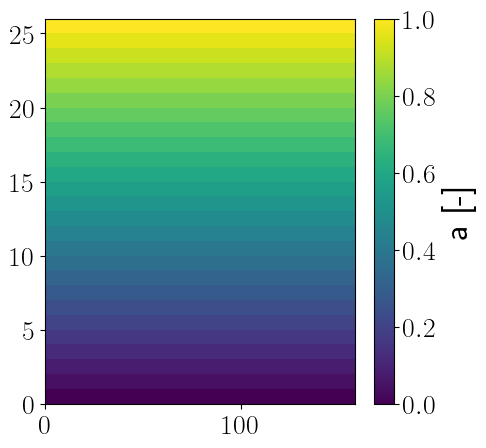

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))

mesh = ax.pcolormesh(R_new, cmap='viridis',vmin=0,vmax=1)
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('a [-]',fontsize=25)

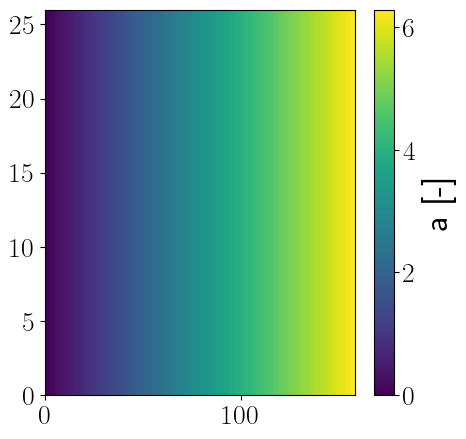

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))

mesh = ax.pcolormesh(Theta_new, cmap='viridis',vmin=0,vmax=(2*np.pi))
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('a [-]',fontsize=25)

In [8]:
a = ((wrfles_bem[count]['rOverR'] * rotor.R) - rotor.hub_radius)/rotor.R
r = (rotor.hub_radius + a * (rotor.R - rotor.hub_radius)) / rotor.R
r

array([0.0424353 , 0.07906064, 0.11568597, 0.15231131, 0.18893664,
       0.22556197, 0.26218731, 0.29881264, 0.33543798, 0.37206331,
       0.40868865, 0.44531398, 0.48193932, 0.51856465, 0.55518998,
       0.59181532, 0.62844065, 0.66506599, 0.70169132, 0.73831666,
       0.77494199, 0.81156733, 0.84819266, 0.88481799, 0.92144333,
       0.95806866])

In [9]:
c = rotor.chord_func(r) 
c

array([4.60154779, 4.67811994, 4.92769627, 5.33375072, 5.76018845,
       6.0123149 , 5.97095646, 5.79194782, 5.54303392, 5.24669724,
       4.92197467, 4.58546315, 4.24800226, 3.91573112, 3.59399347,
       3.28862838, 3.0027801 , 2.73810253, 2.49611741, 2.27522642,
       2.07505371, 1.89577084, 1.73297333, 1.5804057 , 1.40270474,
       1.12250138])

In [10]:
rotor.solidity_func(r)

array([0.52215977, 0.28492976, 0.2051115 , 0.16862709, 0.14680717,
       0.12835199, 0.10966272, 0.0933367 , 0.07957233, 0.06790409,
       0.05799273, 0.04958424, 0.04244428, 0.03636108, 0.03117184,
       0.02675811, 0.02300838, 0.01982493, 0.01712954, 0.01483914,
       0.01289398, 0.01124833, 0.00983839, 0.00860085, 0.00733034,
       0.00564179])

In [11]:
ind = 1 - np.mean(wrfles_bem[count]['u'],axis=0) / 7
ind

array([[0.14835131, 0.14826244, 0.14818048, ..., 0.14865297, 0.14854711,
        0.14844638],
       [0.2014255 , 0.20120162, 0.20085287, ..., 0.2013408 , 0.20149511,
        0.20152348],
       [0.28231478, 0.28197336, 0.2812804 , ..., 0.28123683, 0.28194565,
        0.28230542],
       ...,
       [0.3745619 , 0.39201498, 0.3993228 , ..., 0.35487336, 0.36503732,
        0.37478906],
       [0.31312764, 0.3228625 , 0.3318388 , ..., 0.28086418, 0.29183275,
        0.3027053 ],
       [0.2269193 , 0.23761618, 0.24821693, ..., 0.19610405, 0.20590979,
        0.21626699]], shape=(26, 158), dtype=float32)

In [12]:
sigma = rotor.solidity_func(r.T).T
sigma

array([0.52215977, 0.28492976, 0.2051115 , 0.16862709, 0.14680717,
       0.12835199, 0.10966272, 0.0933367 , 0.07957233, 0.06790409,
       0.05799273, 0.04958424, 0.04244428, 0.03636108, 0.03117184,
       0.02675811, 0.02300838, 0.01982493, 0.01712954, 0.01483914,
       0.01289398, 0.01124833, 0.00983839, 0.00860085, 0.00733034,
       0.00564179])

In [42]:
W

array([[ 1.0237762,  1.023966 ,  1.0239425, ...,  1.0236895,  1.023731 ,
         1.0237601],
       [ 1.2020247,  1.2029133,  1.2029351, ...,  1.2022982,  1.2021412,
         1.2020502],
       [ 1.4304286,  1.4286804,  1.4292021, ...,  1.4315528,  1.4309652,
         1.4305899],
       ...,
       [ 9.573181 ,  9.572325 ,  9.572497 , ...,  9.571454 ,  9.571421 ,
         9.571624 ],
       [ 9.975625 ,  9.975974 ,  9.976392 , ...,  9.975014 ,  9.97505  ,
         9.975172 ],
       [10.3809805, 10.381357 , 10.381734 , ..., 10.379872 , 10.38013  ,
        10.380448 ]], shape=(26, 158), dtype=float32)

In [13]:
phi = np.deg2rad(np.mean(wrfles_bem[count]['phi'], axis=0))
phi

array([[1.0700226 , 1.0696073 , 1.0696521 , ..., 1.0706698 , 1.070379  ,
        1.0701627 ],
       [0.7483839 , 0.74711305, 0.74728876, ..., 0.7496198 , 0.7490531 ,
        0.74864   ],
       [0.5253111 , 0.52571523, 0.52591467, ..., 0.52681273, 0.5260617 ,
        0.52556044],
       ...,
       [0.06322791, 0.06148054, 0.0607557 , ..., 0.06524356, 0.0642047 ,
        0.06321498],
       [0.06661218, 0.0656812 , 0.06482965, ..., 0.06974709, 0.06867538,
        0.06762103],
       [0.07200081, 0.07102305, 0.07006105, ..., 0.0748701 , 0.07395022,
        0.07298826]], shape=(26, 158), dtype=float32)

In [14]:
Cl = np.mean(wrfles_bem[count]['cl'], axis=0)
Cl

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [1.7108746, 1.7092582, 1.70846  , ..., 1.7048668, 1.7078718,
        1.7098771],
       ...,
       [1.1344572, 1.1232021, 1.1185333, ..., 1.1474402, 1.1407489,
        1.1343739],
       [1.0229217, 1.0167619, 1.0111276, ..., 1.0436639, 1.0365728,
        1.0295966],
       [1.0004232, 0.9939539, 0.9875888, ..., 1.019408 , 1.0133215,
        1.0069567]], shape=(26, 158), dtype=float32)

In [15]:
Cd = np.mean(wrfles_bem[count]['cd'], axis=0)
Cd

array([[0.6000002 , 0.6000002 , 0.6000002 , ..., 0.6000002 , 0.6000002 ,
        0.6000002 ],
       [0.6000002 , 0.6000002 , 0.6000002 , ..., 0.6000002 , 0.6000002 ,
        0.6000002 ],
       [0.10766483, 0.10809886, 0.10831317, ..., 0.10927798, 0.10847115,
        0.10793267],
       ...,
       [0.00904311, 0.00894699, 0.00890713, ..., 0.00915398, 0.00909683,
        0.0090424 ],
       [0.00823497, 0.00819444, 0.00815736, ..., 0.00837148, 0.00832482,
        0.0082789 ],
       [0.00808691, 0.00804433, 0.00800244, ..., 0.00821185, 0.00817179,
        0.0081299 ]], shape=(26, 158), dtype=float32)

In [16]:
a = ((wrfles_bem[count]['rOverR'] * rotor.R) - rotor.hub_radius)/rotor.R
r = (rotor.hub_radius + a * (rotor.R - rotor.hub_radius)) / rotor.R
r

array([0.0424353 , 0.07906064, 0.11568597, 0.15231131, 0.18893664,
       0.22556197, 0.26218731, 0.29881264, 0.33543798, 0.37206331,
       0.40868865, 0.44531398, 0.48193932, 0.51856465, 0.55518998,
       0.59181532, 0.62844065, 0.66506599, 0.70169132, 0.73831666,
       0.77494199, 0.81156733, 0.84819266, 0.88481799, 0.92144333,
       0.95806866])

In [17]:
rotor = IEA10MW()

B = 3

# sigma = (B * c) / (2 * np.pi * r * rotor.R)

r =  (np.ones_like(Cd.T) * r).T


sigma = rotor.solidity_func(r)

# sigma = (B) / (2 * np.pi * r * rotor.R)


W = np.mean(wrfles_bem[count]['vrel'], axis=0) / 7

Cax = Cl * np.cos(phi) + Cd * np.sin(phi)

In [18]:
CT = sigma * W**2 * Cax
CT

array([[0.25904278, 0.25915582, 0.25919934, ..., 0.25876775, 0.25887329,
        0.25896521],
       [0.16022145, 0.16053101, 0.1606408 , ..., 0.16004248, 0.16007807,
        0.16013796],
       [0.64450295, 0.64359281, 0.644083  , ..., 0.64078659, 0.64233851,
        0.64357998],
       ...,
       [0.95457231, 0.94460091, 0.94024536, ..., 0.96472582, 0.95943987,
        0.95420106],
       [0.79711875, 0.79201355, 0.78716917, ..., 0.81310227, 0.8077769 ,
        0.80235294],
       [0.65050804, 0.64597544, 0.64138053, ..., 0.66283197, 0.65900341,
        0.65482893]], shape=(26, 158))

In [78]:
bem = BEM(rotor=rotor, geometry=BEMGeometry(Nr=60, Ntheta=360), aerodynamic_model=KraghAerodynamics(), tiploss_model=NoTipLoss(), momentum_model=MadsenMomentum(), tangential_induction_model=NoTangentialInduction())

pitch, tsr, yaw = np.deg2rad(0), 10.634, np.deg2rad(0.0)
sol = bem(pitch, tsr, yaw)

/tmp/ipykernel_3695845/2849340856.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(ind_f, CT_f, cmap='viridis', s=25, edgecolor='k')


(-0.1, 1.75)

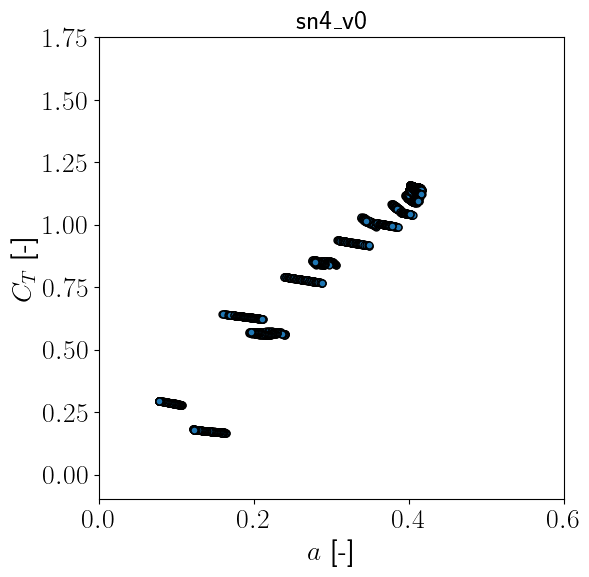

In [75]:
CT_f = CT.flatten()
ind_f  = ind.flatten()


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(ind_f, CT_f, cmap='viridis', s=25, edgecolor='k')
ax.set_ylabel('$C_T$ [-]',fontsize=20)
ax.set_xlabel('$a$ [-]',fontsize=20)
ax.set_title('sn4_v0',fontsize=20)
ax.set_xlim([0,0.6])
ax.set_ylim([-0.1,1.75])

In [ ]:
for count in range(len(casenames)):
    y = (wrfles_wind[count]['Y3'] - wrfles_wind[count]['rotor_yloc'])/(wrfles_wind[count]['diameter']/2)
    z = (wrfles_wind[count]['Z3'] - wrfles_wind[count]['hub_height'])/(wrfles_wind[count]['diameter']/2)

    r     = (y**2 + z**2)**(1/2)
    theta = np.arctan2(y,z)

    ws  = np.mean(wrfles_wind[count]['ux_n4D'], axis=0)
    ind = 1 - np.mean(wrfles_wind[count]['ux_0D'], axis=0) / np.mean(wrfles_wind[count]['ux_n4D'], axis=0)

    # Mask points where r > R
    mask = r <= 1.5
    r_filtered     = r[mask]
    theta_filtered = theta[mask]
    ws_filtered    = ws[mask]
    ind_filtered   = ind[mask]

    # Interpolate to new polar grid
    r_new = np.linspace(0.0, 0.99999, 26)  # 50 points in r
    theta_new = np.linspace(0, 2 * np.pi, 158)  # 100 points in theta
    Theta_new, R_new = np.meshgrid(theta_new, r_new)

    # Convert new polar grid to Cartesian for interpolation
    X_new = R_new * np.sin(Theta_new)
    Y_new = R_new * np.cos(Theta_new)

    # Interpolate data to the new polar grid
    ws_rt = griddata(
        points=(y[mask], z[mask]),
        values=ws_filtered,
        xi=(X_new, Y_new),
        method='linear'
    )

    ind_rt = griddata(
        points=(y[mask], z[mask]),
        values=ind_filtered,
        xi=(X_new, Y_new),
        method='linear'
    )

    rotor = IEA10MW()

    c = rotor.chord_func(r_new)

    dT = 3 * c * np.mean(wrfles_bem[count]['vrel'], axis=0).T**2 * (np.mean(wrfles_bem[count]['cl'], axis=0) * np.cos(np.deg2rad(np.mean(wrfles_bem[count]['phi'], axis=0))) + np.mean(wrfles_bem[count]['cd'], axis=0) * np.sin(np.deg2rad(np.mean(wrfles_bem[count]['phi'], axis=0)))).T

    dynamo = ws_rt.T

    temp[count] = dT * wrfles_wind[count]['rOverR'] * 199/2/(ws_rt.T**2 * Ad)

IndexError: list assignment index out of range

/tmp/ipykernel_196613/4233399215.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='PiYG',vmin=-10,vmax=10)
/tmp/ipykernel_196613/4233399215.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='PiYG',vmin=-10,vmax=10)
/tmp/ipykernel_196613/4233399215.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasi

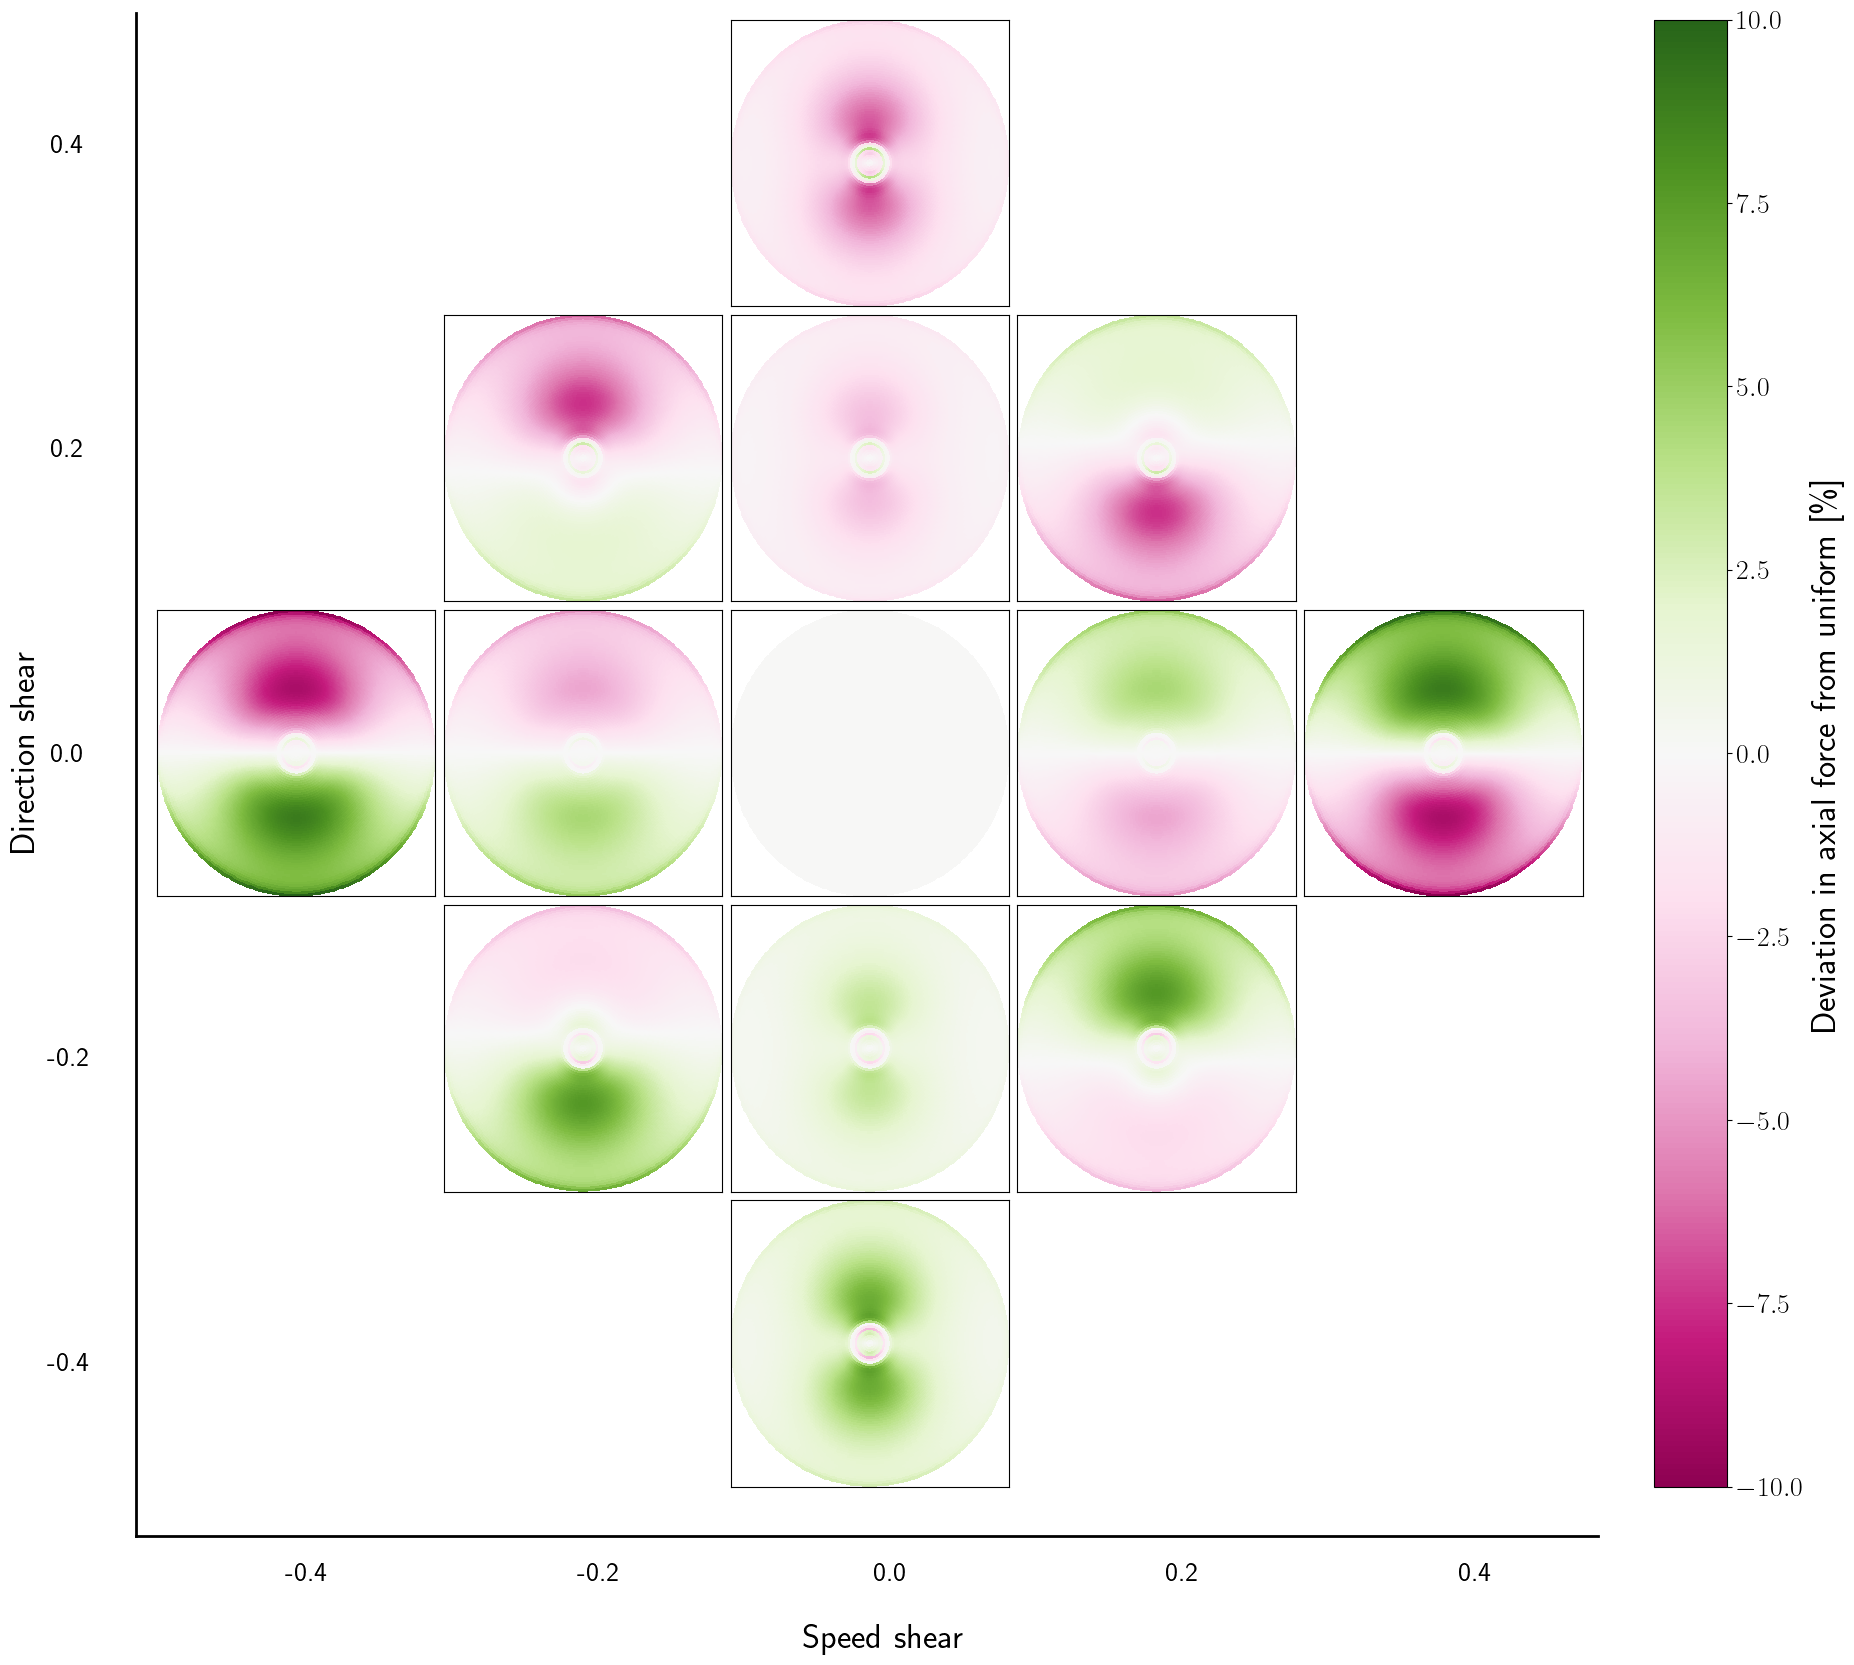

In [45]:
# AXIAL FORCE DEVIATION

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    
ref_case = solutions[ref].Cax('sector')

for i in range(len(xs)):
    current = solutions[i].Cax('sector')
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='PiYG',vmin=-10,vmax=10)
    # ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Deviation in axial force from uniform [\%]',fontsize=25)




# Add the number line below the subplots
line_y = -0.02  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.01, 0.85  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.1  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.43, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.01  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.02, 0.995  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.11  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.03,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.44, 'Direction shear', ha='center', fontsize=25,rotation=90)

plt.show()

In [5]:
y = (wrfles_wind[count]['Y3'] - wrfles_wind[count]['rotor_yloc'])/(wrfles_wind[count]['diameter']/2)
z = (wrfles_wind[count]['Z3'] - wrfles_wind[count]['hub_height'])/(wrfles_wind[count]['diameter']/2)

r     = (y**2 + z**2)**(1/2)
theta = np.arctan2(y,z)

ws  = ((np.mean(wrfles_wind[count]['ux_n4D'], axis=0)**2 + np.mean(wrfles_wind[count]['vx_n4D'], axis=0)**2)**(1/2) / wrfles_wind[count]['uinf'])
wd  = (np.arctan2(np.mean(wrfles_wind[count]['vx_n4D'], axis=0), np.mean(wrfles_wind[count]['ux_n4D'], axis=0)))

# ws  = ((np.mean(wrfles_wind[count]['ux_0D'], axis=0)**2 + np.mean(wrfles_wind[count]['vx_0D'], axis=0)**2)**(1/2) / wrfles_wind[count]['uinf'])
# wd  = (np.arctan2(np.mean(wrfles_wind[count]['vx_0D'], axis=0), np.mean(wrfles_wind[count]['ux_0D'], axis=0)))

ct  = np.mean(wrfles_wind[count]['ct'],  axis=0)
cp  = np.mean(wrfles_wind[count]['cp'],  axis=0)
cl  = np.mean(wrfles_wind[count]['cl'],  axis=0)
cd  = np.mean(wrfles_wind[count]['cd'],  axis=0)
aoa = np.mean(wrfles_wind[count]['aoa'], axis=0)
f   = np.mean(wrfles_wind[count]['f'],   axis=0)
fn  = np.mean(wrfles_wind[count]['fn'],  axis=0)
ft  = np.mean(wrfles_wind[count]['ft'],  axis=0)
vd  = np.mean(wrfles_wind[count]['v1'],  axis=0)

Ad = np.pi * (wrfles_wind[count]['diameter']/2)**2

# Mask points where r > R
mask = r <= 1.5
r_filtered     = r[mask]
theta_filtered = theta[mask]
ws_filtered    = ws[mask]
wd_filtered    = wd[mask]

# Interpolate to new polar grid
r_new = np.linspace(0.0, 0.99999, 60)  # 50 points in r
theta_new = np.linspace(0, 2 * np.pi, 360)  # 100 points in theta
Theta_new, R_new = np.meshgrid(theta_new, r_new)

# Convert new polar grid to Cartesian for interpolation
X_new = R_new * np.sin(Theta_new)
Y_new = R_new * np.cos(Theta_new)

# Interpolate data to the new polar grid
ws_rt = griddata(
    points=(y[mask], z[mask]),
    values=ws_filtered,
    xi=(X_new, Y_new),
    method='linear'
)
# Interpolate data to the new polar grid
wd_rt = griddata(
    points=(y[mask], z[mask]),
    values=wd_filtered,
    xi=(X_new, Y_new),
    method='linear'
)

cl_r = wrfles_wind[count]['rOverR']
# cl_t = np.linspace(0, 2 * np.pi, 158) + np.pi/2
cl_t = np.linspace(0, 2 * np.pi, 158)

cl_T, cl_R = np.meshgrid(cl_t, cl_r)

cl_x = cl_R * np.sin(cl_T)
cl_y = cl_R * np.cos(cl_T)

cl_r_new = np.linspace(0.0, 0.99999, 60)
# cl_t_new = np.linspace(0, 2 * np.pi, 360) + np.pi/2
cl_t_new = np.linspace(0, 2 * np.pi, 360)

cl_T_new, cl_R_new = np.meshgrid(cl_t_new, cl_r_new)

cl_x_new = cl_R_new * np.cos(cl_T_new)
cl_y_new = cl_R_new * np.sin(cl_T_new)

# Mask points where r > R
mask = r <= 1.5
r_filtered     = r[mask]
theta_filtered = theta[mask]
ws_filtered    = ws[mask]
wd_filtered    = wd[mask]

# Interpolate to new polar grid
r_new = np.linspace(0.0, 1.05, 60)  # 50 points in r
theta_new = np.linspace(0, 2 * np.pi, 360)  # 100 points in theta
Theta_new, R_new = np.meshgrid(theta_new, r_new)

# Convert new polar grid to Cartesian for interpolation
X_new = R_new * np.sin(Theta_new)
Y_new = R_new * np.cos(Theta_new)

# Initialize rotor with increased radial resolution.
rotor = IEA10MW()

# bem = BEM(rotor=rotor, geometry=BEMGeometry(Nr=60, Ntheta=360), aerodynamic_model=KraghAerodynamics(), tiploss_model=NoTipLoss(), momentum_model=ConstantInduction(), tangential_induction_model=DefaultTangentialInduction())
# bem = BEM(rotor=rotor, geometry=BEMGeometry(Nr=60, Ntheta=360), aerodynamic_model=KraghAerodynamics(), tiploss_model=NoTipLoss(), momentum_model=ClassicalMomentum(), tangential_induction_model=NoTangentialInduction())
bem = BEM(rotor=rotor, geometry=BEMGeometry(Nr=60, Ntheta=360), aerodynamic_model=KraghAerodynamics(), tiploss_model=NoTipLoss(), momentum_model=MadsenMomentum(), tangential_induction_model=NoTangentialInduction())


pitch, tsr, yaw = np.deg2rad(0), 10.634, np.deg2rad(0.0)
sol = bem(pitch, tsr, yaw, U=ws_rt, wdir=wd_rt)

In [31]:
bem = BEM(rotor=rotor, geometry=BEMGeometry(Nr=60, Ntheta=360), aerodynamic_model=KraghAerodynamics(), tiploss_model=NoTipLoss(), momentum_model=MadsenMomentum(), tangential_induction_model=NoTangentialInduction())
pitch, tsr, yaw = np.deg2rad(0), 10.634, np.deg2rad(0.0)
sol = bem(pitch, tsr, yaw)

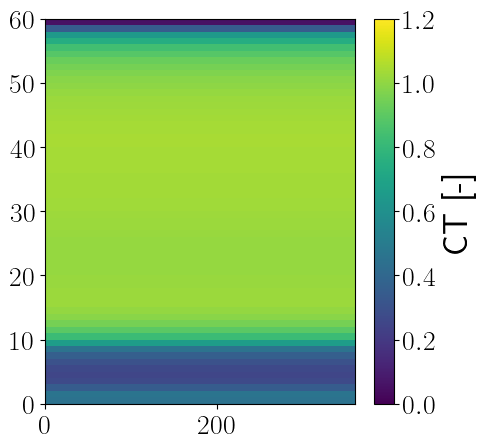

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))

mesh = ax.pcolormesh(sol.Ct('sector'), cmap='viridis',vmin=0,vmax=1.2)
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('CT [-]',fontsize=25)

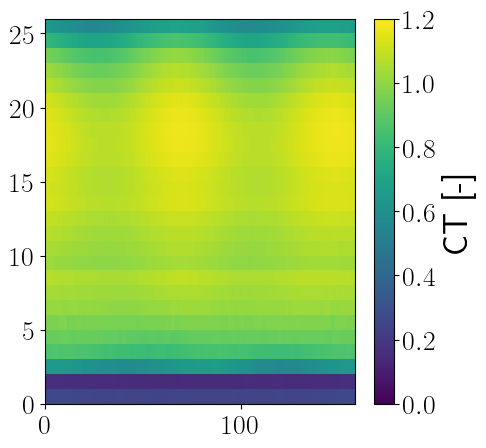

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))

mesh = ax.pcolormesh(CT, cmap='viridis',vmin=0,vmax=1.2)
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('CT [-]',fontsize=25)

/tmp/ipykernel_3695845/1740068005.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(a_f, ct_f, cmap='viridis', s=25, edgecolor='k')


(-0.1, 1.75)

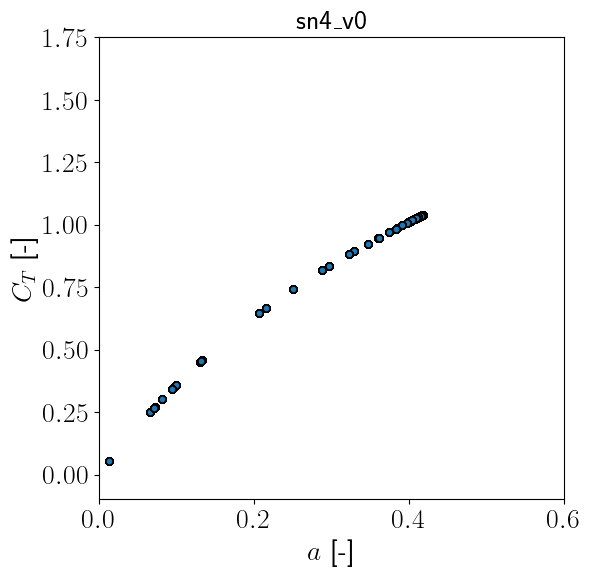

In [77]:
ct_f = sol.Ct('sector')
a_f  = sol.a('sector')


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(a_f, ct_f, cmap='viridis', s=25, edgecolor='k')
ax.set_ylabel('$C_T$ [-]',fontsize=20)
ax.set_xlabel('$a$ [-]',fontsize=20)
ax.set_title('sn4_v0',fontsize=20)
ax.set_xlim([0,0.6])
ax.set_ylim([-0.1,1.75])

In [76]:
sol.Ct('sector')

array([[0.45255895, 0.45255895, 0.45255895, ..., 0.45255895, 0.45255895,
        0.45255895],
       [0.45960226, 0.45960226, 0.45960226, ..., 0.45960226, 0.45960226,
        0.45960226],
       [0.34529281, 0.34529281, 0.34529281, ..., 0.34529281, 0.34529281,
        0.34529281],
       ...,
       [0.64528053, 0.64528053, 0.64528053, ..., 0.64528053, 0.64528053,
        0.64528053],
       [0.34223452, 0.34223452, 0.34223452, ..., 0.34223452, 0.34223452,
        0.34223452],
       [0.05387007, 0.05387007, 0.05387007, ..., 0.05387007, 0.05387007,
        0.05387007]], shape=(60, 360))

NameError: name 'sol' is not defined

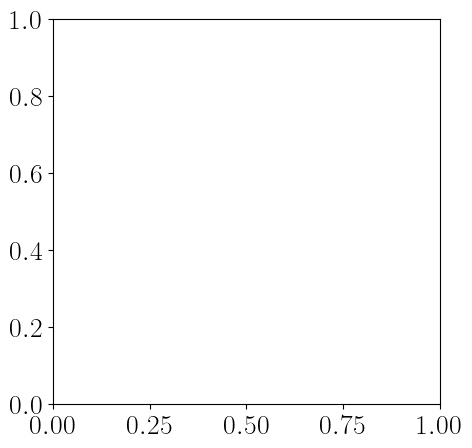

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))

mesh = ax.pcolormesh(sol.a('sector'), cmap='viridis',vmin=0,vmax=0.5)
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('a [-]',fontsize=25)

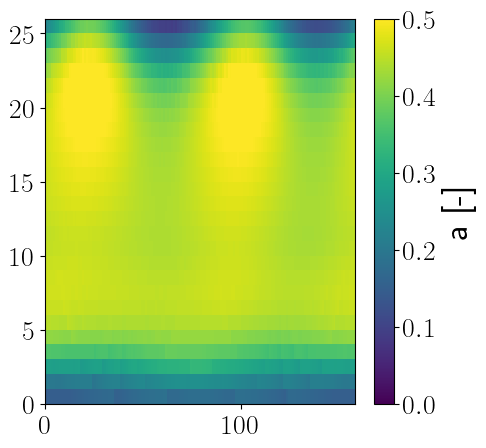

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))

mesh = ax.pcolormesh(ind, cmap='viridis',vmin=0,vmax=0.5)
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('a [-]',fontsize=25)

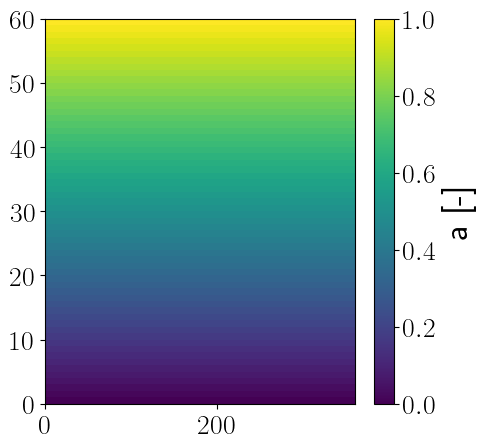

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))

mesh = ax.pcolormesh(sol.geom.mu_mesh, cmap='viridis',vmin=0,vmax=1)
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('a [-]',fontsize=25)

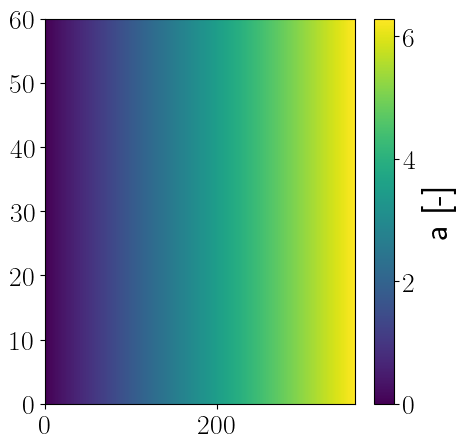

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))

mesh = ax.pcolormesh(sol.geom.theta_mesh, cmap='viridis',vmin=0,vmax=(2*np.pi))
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('a [-]',fontsize=25)